In [ ]:
import os
import zipfile
import json
import copy
from typing import Optional, List, Tuple, Dict
import PIL

import numpy as np
from torch import nn

from torch.utils.data import DataLoader, Dataset

from helper import show_one

In [2]:
class MasterDataset(Dataset):
    def __init__(self, 
                 name       : str,                     # Name of the Dataset
                 raw_shape  : List,                    # Raw shape of the images [B, C, H, W]
                 max_size   : Optional[int] = None,    # Artificially limit the size of the dataset. None = no limit. Applied before xflip.
                 use_labels : bool = True,            # Enable conditioning labels? False = label dimension is zero.
                 xflip      : bool = False,            # Artificially double the size of the dataset via x-flips. Applied after max_size.
                 random_seed: Optional[int] = 1,       # Random seed to use when applying max_size.
                 ):
        super().__init__()
        
        self._name        = name
        self._raw_shape   = list(raw_shape)
        self._use_labels  = use_labels
        self._raw_labels  = None
        self._label_shape = None

        self._raw_idx = np.arange(self._raw_shape[0], dtype = np.int64)
        self._base_raw_idx = copy.deepcopy(self._raw_idx)
        if (max_size is not None) and len(self._raw_shape[0]) > max_size:
            np.random.RandomState(random_seed).shuffle(self._raw_idx)
            self._raw_idx = np.sort(self._raw_idx[:max_size])

        self.xflip = np.zeros_like(self._raw_idx)       # self.xflip:   [0, 1, 2...]
        if xflip:
            self._raw_idx = np.tile(self._raw_idx, 2)   # 2; Doubling Dataset
                                                        # self._raw_idx: [0, 1, 2.. , 0, 1, 2...]
            self.xflip = np.concatenate((self.xflip, np.ones_like(self._raw_idx)))
                                                        # self.xflip: [0, 0, 0.. , 1, 1, 1...]

    def set_dynamic_lenght(self, new_len: int):
        self._raw_idx = self._base_raw_idx[:new_len]

    def _load_raw_labels():
        # This must be Implmented later on with different class
        raise NotImplemented
    
    def _load_raw_image(self, raw_idx: int) -> None: # to be overridden by subclass
        raise NotImplementedError
    
    def close(self) -> None: # to be overridden by subclass
        pass

    def __del__(self) -> None:
        try:
            self.close()
        except:
            pass

    @staticmethod
    def _file_ext(fname: str) -> str:
        # gets the format, ex: .zip, .png etc
        return os.path.splitext(fname)[1].lower() 

    def __getstate__(self) -> dict:
        return dict(self.__dict__, _raw_labels=None)
    
    # def set_class(self, cls_list: List) -> None:
    #     self._raw_labels = self._load_raw_labels()  
    #     print("raw labels: " , self._raw_labels, type(self._raw_labels))

    #     new_idcs = [self._raw_labels == cl for cl in cls_list]     # new_idcs: [True, False, False...]
    #     new_idcs = np.sum(np.vstack(new_idcs), 0)                  # new_idcs: [1   , 0    , 0    ...]
    #     new_idcs = np.where(new_idcs)                              # new_idcs: [2,3..]
    #     print("new_idcs: ", new_idcs, type(new_idcs))
    #     self._raw_idx = self._base_raw_idx[new_idcs]
    #     print("_raw_idx: " , self._raw_idx, type(self._raw_idx))
    #     assert all(sorted(cls_list) == np.unique(self._raw_labels[self._raw_idx])) # cls_list == unique labels
    #     print(f"Training on the following classes: {cls_list}")
    
    def _get_raw_labels(self) -> np.ndarray:
        if self._raw_labels is None:
            self._raw_labels = self._load_raw_labels() if self._use_labels else None
            if self._raw_labels is None:
                self._raw_labels = np.zeros([self._raw_shape[0], 0], dtype=np.float32)

            assert isinstance(self._raw_labels, np.ndarray)
            assert self._raw_labels.shape[0] == self._raw_shape[0] # Same Batch size
            assert self._raw_labels.dtype.type in [np.float32, np.int64, np.str_]
            if self._raw_labels.dtype == np.int64:          # If one hot encoded
                assert self._raw_labels.ndim == 1
                assert np.all(self._raw_labels >= 0)
        return self._raw_labels
    
    def __len__(self) -> int:
        # return self._raw_idx.shape[0]
        return len(self._raw_idx)
    
    def get_label(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        label = self._get_raw_labels()[self._raw_idx[idx]]
        if label.dtype == np.int64:
            one_hot = np.zeros(self._label_shape, dtype=np.float32)
            one_hot[label] = 1
            label = one_hot
        assert isinstance(np.array(label), np.ndarray)
        return label.copy()
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        image = self._load_raw_image(self._raw_idx[idx])
        if self.xflip[idx]:              # if xflip[idx] is 1; refer line 28
            assert image.ndim == 3       #[C, H, W]
            image = image[:, : , ::-1]   # reverses the Width; flips it
        assert isinstance(image, np.ndarray)
        assert image.dtype == np.uint8

        label = self.get_label(idx)
        if '.' in label:           # Possible extension still attached
            possible_ext = self._file_ext(label)
            if possible_ext in PIL.Image.EXTENSION: label = ''.join(label.split(".")[:-1])
        return image.copy(), label
    
    def get_details(self, idx: int) -> Dict:
        d = {}
        d["raw_idx"] = int(self._raw_idx[idx])
        d["xflip"] = int(self.xflip[idx] != 0)
        d["raw_label"] = self._get_raw_labels()[self._raw_idx[idx]].copy()
        return d
    
    @property
    def name(self) -> str:
        return self._name

    @property
    def image_shape(self) -> list:
        return list(self._raw_shape[1:])

    @property
    def num_channels(self) -> int:
        assert len(self.image_shape) == 3 # CHW
        return self.image_shape[0]
    
    @property
    def label_shape(self) -> List:
        if self._label_shape is None:
            raw_labels = self._get_raw_labels()
            if isinstance(raw_labels, dict):
                self._label_shape = [1]
            
            elif isinstance(raw_labels, np.int64):
                self._label_shape = [1 + np.max(raw_labels)]

            elif isinstance(raw_labels, np.str_):
                self._label_shape = [1]

            else:
                self._label_shape = raw_labels.shape[1:]
        return list(self._label_shape)
    
    @property
    def label_dim(self) -> int:
        assert len(self.label_shape) == 1
        return self.label_shape[0]
    
    @property
    def has_labels(self) -> bool:
        return any(x != 0 for x in self.label_shape)
    
    @property
    def labels_are_text(self) -> bool:
        raw_labels = self._get_raw_labels()
        if isinstance(raw_labels, dict):
            return True  # TODO: dict = zip dataset, fix this
        else:
            return raw_labels.dtype.type == np.str_
        
    @property
    def has_onehot_labels(self) -> bool:
        return self._get_raw_labels().dtype == np.int64

In [3]:
class StyleDataset(MasterDataset):
    def __init__(self, 
                 path      : str,                  # Path to directory or zip file
                 resolution: Optional[int] = None, # resolution of image; None = highest available.
                 **kwargs
                 ):
        # super().__init__()

        self._path = path
        self._zipfile = None
        self.resolution = resolution
        self.interpolated = self.resolution is not None
  
        # os.walk           -> [root, director, files]
        # os.path.relpath   -> returns relative path (from current directory)

        if os.path.isdir(self._path):
            self._type = "dir"
            self._all_fnames = {os.path.relpath(os.path.join(root, fname))
                                for root, _, files in os.walk(self._path)
                                for fname in files}
                                # This will get all director and subdirectory's realive path iteratively
            self._all_fnames = ['/'.join(f.split('/')[1:]) for f in self._all_fnames]
        elif self._file_ext(self._path) == ".zip":
            self._type == "zip"
            self._all_fnames = set(self._get_zipfile().namelist())
        else:
            raise IOError('Path must point to a directory or zip')
        
        PIL.Image.init()
        self._image_fnames = sorted(fname for fname in self._all_fnames if self._file_ext(fname) in PIL.Image.EXTENSION)
        if len(self._image_fnames) == 0: raise IOError("No images found in this directory")
        
        name = os.path.splitext(os.path.basename(self._path))[0] # Basically from ".../Networks/dataset.zip" -> "dataset"; if zip
                                                                    #             or ".../Networks/dataset"     -> "dataset"; if dir
        raw_shape = [len(self._image_fnames)] + list(self._load_raw_image(0).shape)  # [B, C, H, W]
        if resolution is not None and (raw_shape[2] != resolution or raw_shape[3] != resolution):
            self.interpolate = True
        super().__init__(name=name, raw_shape=raw_shape, **kwargs)

    
    def _get_zipfile(self) -> zipfile.ZipFile:
        assert self._type == ".zip"
        if self._zipfile is None:
            self._zipfile = zipfile.ZipFile(self._path)
        return self._zipfile
    
    # def _open_file(self, fname: str) -> PIL.Image:
    #     if self._type == 'dir':
    #         print(self._path)
    #         print(fname)
    #         return open((self._path + fname), "rb")
    #     if self._type == 'zip':
    #         return self._get_zipfile().open(fname, 'r') # zipfile.ZipFile.open() returns a binary file-like object by default
    #     return None

    def _open_file(self, fname: str):
        full_path = os.path.join(self._path, fname)
        if self._type == 'dir':
            if fname.endswith(".json"):
                return open(full_path, "r")   # Open as text
            else:
                return open(full_path, "rb") # Open images as binary
        elif self._type == 'zip':
            return self._get_zipfile().open(fname, 'r')
        return None
    
    def _close_file(self) -> None:
        try:
            if self._zipfile is not None:
                self._zipfile.close()
        finally:
            self._zipfile = None

    @staticmethod
    def scale(width: int, height: int, img: np.ndarray) -> np.ndarray:
        # img: [H, W, C]
        h = img.shape[0]
        w = img.shape[1]

        if width == h and height == h: return img
        ww = width if width is not None else w
        hh = height if height is not None else h
        pil_img = PIL.Image.fromarray(img)
        pil_img = pil_img.resize((ww, hh), PIL.Image.LANCZOS)
        return np.array(pil_img)

    def _load_raw_image(self, raw_idx: int) -> np.ndarray:
        fname = self._image_fnames[raw_idx]
        with self._open_file(fname) as f:
            image = np.array(PIL.Image.open(f))
        
        if self.interpolated:
            image = self.scale(self.resolution, self.resolution, image)

        if image.ndim == 2:
            image = image[:, :, np.newaxis] # [H, W] -> [H, W, C=1]; Grayscale image

        image = image.transpose(2, 0, 1)    # [C, H, W]
        return image
    
    def _load_raw_labels(self) -> np.ndarray:
        fname = "data.json"
        if fname not in self._all_fnames: return None
        with self._open_file(fname) as f:
            labels = json.load(f)['labels']
        labels = list(labels.keys())
        if labels is None: return None
        labels = np.array(labels)
        
        if isinstance(labels[0], str): 
            return labels

        labels = labels.astype({1: np.int64, 2: np.float32}[labels.ndim])
        return labels

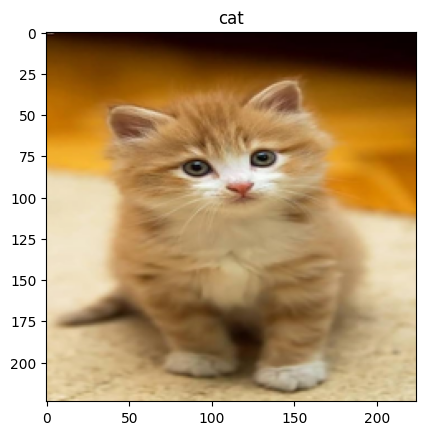

In [11]:
sd = StyleDataset(path="/Users/mohamedmafaz/Desktop/StyleGAN-T/notebooks/Networks/dataset/", resolution=224)
sdl = DataLoader(sd, 3, shuffle=True)
out = next(iter(sdl))

show_one(out[0][1], out[1][1])